
## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `TF-IDF` + `Agglomerative Clusterinng` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
import re
import string

In [63]:
df = pd.read_csv('Datas/data.csv')
df.head()
df.sample(n=5)

,category,title,content
965,Siyasi,Mavi Vatan,"Mavi Vatan, Türkiye Cumhuriyeti'nin Karadeniz,..."
230,Doğal Afetler,557 Konstantinopolis depremi,"557 Konstantinopolis depremi, 14 Aralık gecesi..."
782,Savaşlar,2003 İstanbul saldırıları,"15 ve 20 Kasım 2003 tarihlerinde, İstanbul'un ..."
943,Siyasi,Aferistler,"Aferistler ya da İş Bankası Grubu, Türkiye Cu..."
32,Siyasi,Karadeniz Ekonomik İşbirliği,Karadeniz Ekonomik İşbirliği Örgütü (KEİÖ) (İn...


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)


In [3]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

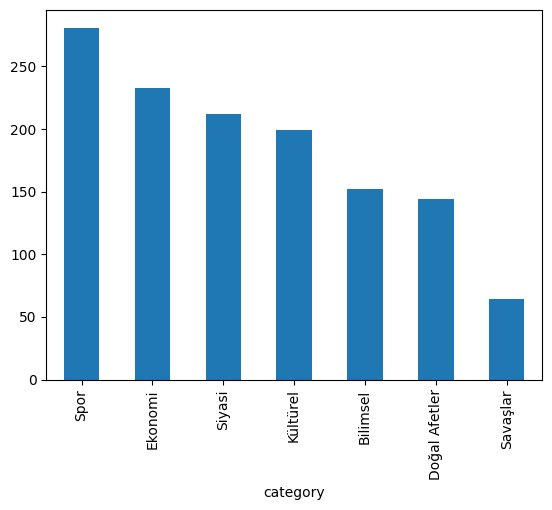

In [4]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # İstersen parametre ekleyebilirsin

X = vectorizer.fit_transform(df['processed_data'])


In [50]:
from sklearn.cluster import AgglomerativeClustering

# Küme sayısı belirleyelim (örnek: 7)
num_clusters = 7

agglo = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X.toarray())

df['cluster'] = clusters

df[['category', 'cluster']].head()
df.sample(n=5)


,category,title,content,processed_data,cluster
757,Kültürel,Dünya Rakı Festivali,Dünya Rakı Festivali Türkiye'nin Adana kentind...,dünya rakı festivali türkiyenin adana kentinde...,1
335,Doğal Afetler,2009 Marmara sel dizisi,2009 Marmara sel dizisi 9 Eylül 2009 tarihinde...,marmara sel dizisi eylül tarihinde türkiyenin ...,1
730,Kültürel,2021 İslami Dayanışma Oyunları'nda güreş,2021 İslami Dayanışma Oyunları'nda güreş 10-13...,i̇slami dayanışma oyunlarında güreş ağustos ta...,2
1229,Spor,2023 Vehbi Emre & Hamit Kaplan Turnuvası,"2023 Vehbi Emre & Hamit Kaplan Turnuvası, 21-2...",vehbi emre hamit kaplan turnuvası haziran tari...,2
670,Kültürel,a,ATÖLYE HBİ Karadeniz Teknik Üniversitesi (KTÜ)...,atölye hbi̇ karadeniz teknik üniversitesi ktü ...,1


In [56]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

# Gerçek kategorileri sayısala dönüştür
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

# Kümeleme sonuçları (senin clustering sonucu)
clusters = agglo.fit_predict(X.toarray())

cluster_label_map = {}

# Her cluster için en çok bulunan kategori sayısal kodunu bul
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        print("Boş küme atlandı")
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num  # burada atama yapılmalı

# Sayısal kodları string kategori isimlerine dönüştür
cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0] 
                        for cluster_id, num in cluster_label_map.items()}

# Tahmin edilen sayısal kategoriler (cluster'dan tahmin edilen kategori)
predicted_num_categories = np.array([cluster_label_map[c] for c in clusters])

# Sayısal kategorileri tekrar orijinal string label'a çevir
predicted_categories = le.inverse_transform(predicted_num_categories)

# Gerçek kategoriler
true_categories = df['category'].values

# Doğruluk ölçümü
accuracy = accuracy_score(true_categories, predicted_categories)

print(f"Cluster-label eşleştirilmiş doğruluk: {accuracy:.4f}")

# Eğer cluster_label_map_str sözlüğünü kullanarak grafik vs yapacaksan bunu kullanabilirsin
print("Cluster - Gerçek kategori eşleşmeleri:")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")


Cluster-label eşleştirilmiş doğruluk: 0.5307
Cluster - Gerçek kategori eşleşmeleri:
Cluster 0 -> Spor
Cluster 1 -> Ekonomi
Cluster 2 -> Spor
Cluster 3 -> Spor
Cluster 4 -> Kültürel
Cluster 5 -> Doğal Afetler
Cluster 6 -> Siyasi


In [60]:
import joblib

# Model ve vectorizer'ı kaydet
joblib.dump(agglo, 'Models/agglo_model.joblib')
joblib.dump(vectorizer, 'Models/tfidf_vectorizer.joblib')

# Daha sonra tekrar yüklemek için
agglo_loaded = joblib.load('Models/agglo_model.joblib')
vectorizer_loaded = joblib.load('Models/tfidf_vectorizer.joblib')


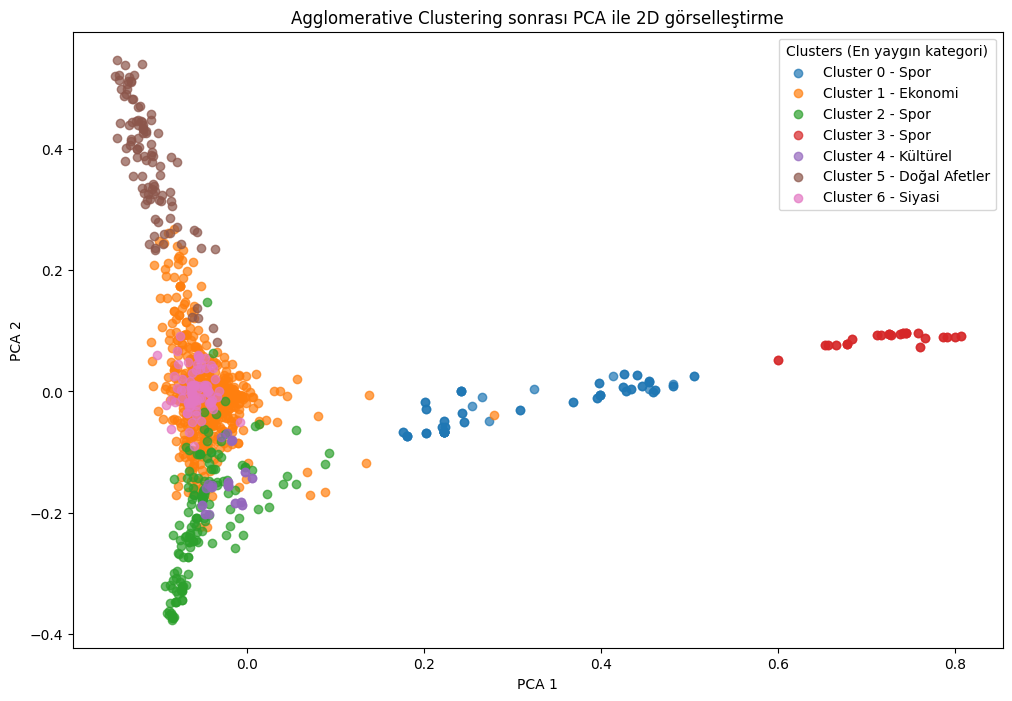

In [57]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters = len(np.unique(clusters))
colors = plt.cm.tab10.colors

plt.figure(figsize=(12,8))

for cluster_id in range(num_clusters):
    idx = np.where(clusters == cluster_id)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], 
                color=colors[cluster_id % 10], 
                label=f"Cluster {cluster_id} - {cluster_label_map_str[cluster_id]}", 
                alpha=0.7)


plt.title('Agglomerative Clustering sonrası PCA ile 2D görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Clusters (En yaygın kategori)", loc='upper right')
plt.show()


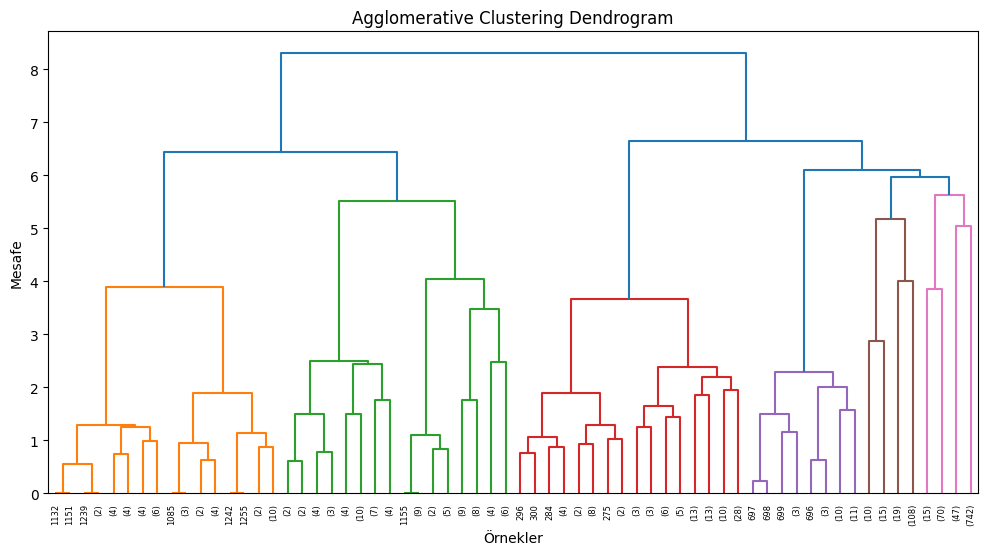

In [27]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X.toarray(), method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # sadece ilk 5 seviyeyi gösterir
plt.title('Agglomerative Clustering Dendrogram')
plt.xlabel('Örnekler')
plt.ylabel('Mesafe')
plt.show()


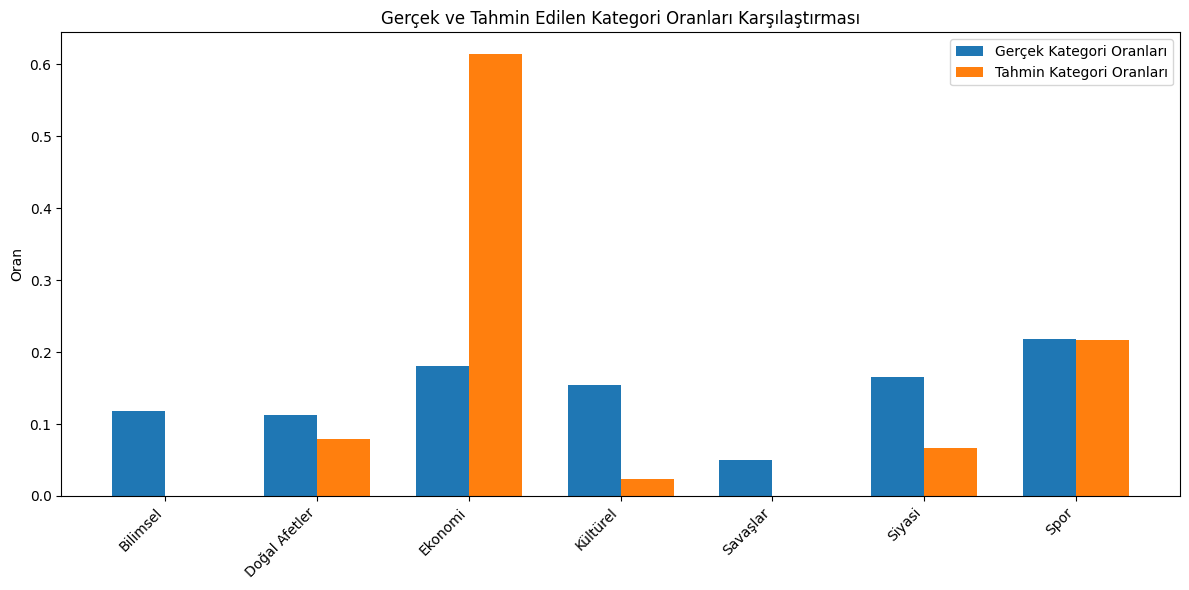

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Gerçek kategori oranları
true_counts = df['category'].value_counts(normalize=True).sort_index()

# Tahmin edilen kategori oranları
predicted_counts = pd.Series(predicted_categories).value_counts(normalize=True).sort_index()

# Tüm kategoriler (gerçek ve tahmin edilenlerde birleşik)
all_categories = sorted(set(true_counts.index).union(predicted_counts.index))

true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, true_vals, width, label='Gerçek Kategori Oranları')
rects2 = ax.bar(x + width/2, predicted_vals, width, label='Tahmin Kategori Oranları')

ax.set_ylabel('Oran')
ax.set_title('Gerçek ve Tahmin Edilen Kategori Oranları Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()
